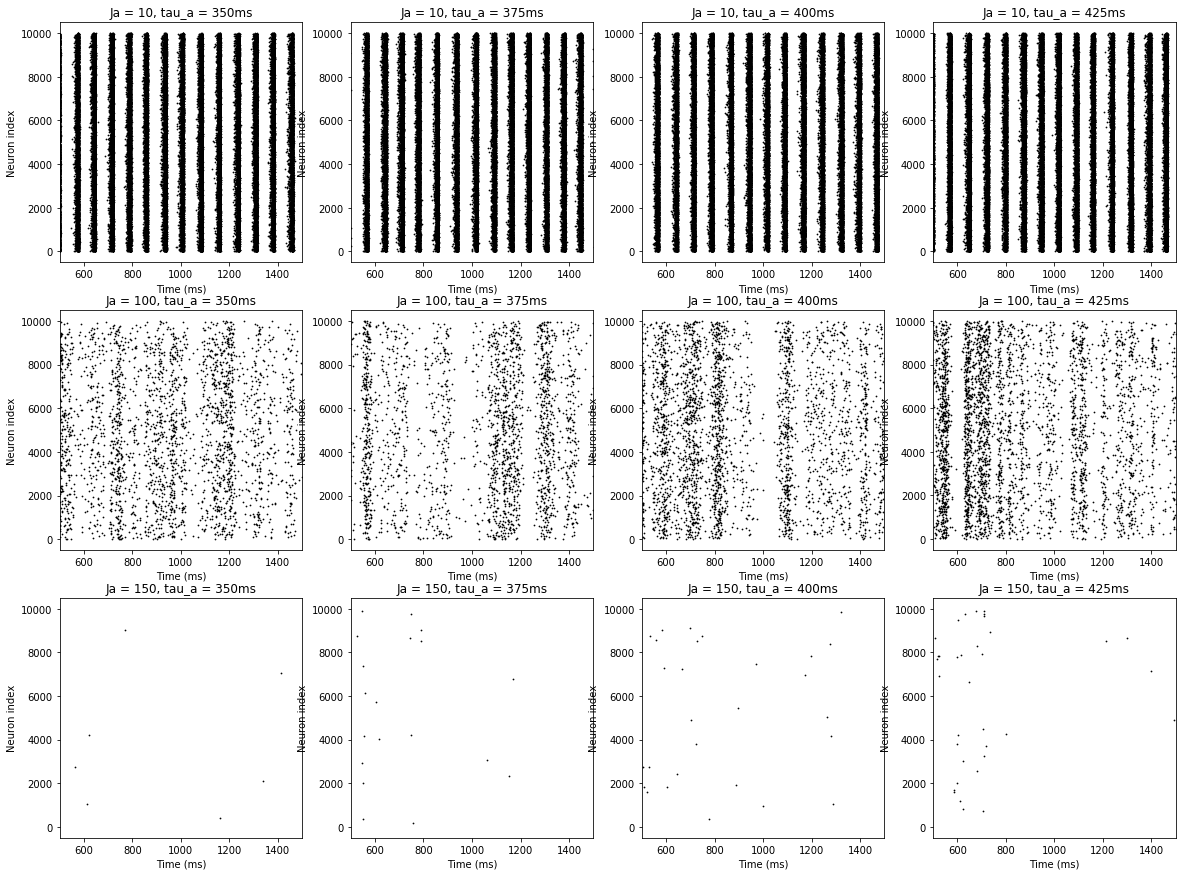

"\ndata1 = M_Ge.get_states(['V_e'])\nwith open('M_Ge.pickle', 'wb') as f:\n    pickle.dump(data1, f)\n\ni,t = Ms_Ge.it\n\ni = np.asarray(i); t = np.asarray(t)\n\nwith open('Ms_Ge.pickle', 'wb') as f:\n    pickle.dump((i,t), f)\n\n"

In [14]:
# Simulating balanced E-I network with disordered connectivity and spike frequency adaptation.
# The network parameters match the spatial network implemented in Section2.

from brian2 import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


defaultclock.dt = 1*ms

c=15 # hyperparameter for scaling synaptic weights. 

# excitatory neurons
tau_ref = 1.5*ms; tau_m = 15*ms
El = -60*mV; Vt = -50*mV; Dt_e = 2*mV; Vre = -65*mV; Vth = -10*mV

# inhibitory neurons
tau_m_i = 10*ms; Dt_i = 0.5*mV; tau_ref_i = 0.5*ms

# synapses
rows_p, cols_p = 25, 25
rows_e, cols_e = 100, 100
rows_i, cols_i = 50, 50

N = rows_e*rows_e + rows_i*rows_i

p_fe = 0.1; p_fi = 0.05;
p_ee = 0.01; p_ei = 0.03; p_ie = 0.04; p_ii = 0.04

j_fe = (140/np.sqrt(N))*mV; j_fi = (100/np.sqrt(N))*mV;
j_ee = (80/np.sqrt(N))*mV; j_ei = (40/np.sqrt(N))*mV; 
j_ie = (240/np.sqrt(N))*mV; j_ii = (300/np.sqrt(N))*mV; 

tau_re = 1*ms; tau_de = 5*ms;
tau_ri = 1*ms; tau_di = 8*ms;

j_a_range = [10 , 100, 150];
tau_a_range = [350, 375, 400,425];

cnt = 1
fig = plt.figure(figsize=(20,15))

spikeTimes = []; spikeInd = []

for ind_j_a,i in enumerate(j_a_range):
    for ind_tau_a,j in enumerate(tau_a_range):
        

        j_a = (i/np.sqrt(N))*mV

        # synapse equations
        tau_ra = 1*ms; tau_da = j*ms

        # equations for excitatory neurons
        eqns_e = '''
        dV_e/dt = (-(V_e-El) + Dt_e*exp((V_e-Vt)/Dt_e) + I_e + I_ie + I_a)/tau_m : volt

        dI_a/dt = (-I_a + a_a)/tau_da : volt
        da_a/dt = -a_a/tau_ra : volt

        dI_e/dt = (-I_e + a_e)/tau_de : volt
        da_e/dt = -a_e/tau_re : volt

        dI_ie/dt = (-I_ie + a_ie)/tau_di : volt
        da_ie/dt = -a_ie/tau_ri : volt
        '''

        # equations for inhibitory neurons
        eqns_i = '''
        dV_i/dt = (-(V_i-El) + Dt_i*exp((V_i-Vt)/Dt_i) + I_i + I_fi)/tau_m_i : volt

        dI_i/dt = (-I_i + a_i)/tau_di : volt
        da_i/dt = -a_i/tau_ri : volt

        dI_fi/dt = (-I_fi + a_fi)/tau_de : volt
        da_fi/dt = -a_fi/tau_re : volt
        '''


        G_e = NeuronGroup(rows_e * cols_e, eqns_e, threshold='V_e>Vth', reset='V_e=-65*mV', refractory=tau_ref, method='euler')
        G_e.V_e = ((Vre - Vth)*np.random.rand(rows_e*cols_e)) + Vre


        G_i = NeuronGroup(rows_i * cols_i, eqns_i, threshold='V_i>Vth', reset='V_i=-65*mV', refractory=tau_ref_i, method='euler')
        G_i.V_i = ((Vre - Vth)*np.random.rand(rows_i*cols_i)) + Vre

        # layer 1 poisson neurons

        P = NeuronGroup(rows_p * cols_p, 'rate : Hz', threshold='rand() < rate*dt', method='euler')
        P.rate = 10*Hz


        ## Layer 1 to Layer 2 feedforward connections

        # Fe connections

        eqns_fe = '''
        w:volt
        w_a:volt
        '''

        eqns_act_fe = '''
        a_e+=w
        a_a+=w_a
        '''

        S_fe = Synapses(P, G_e, eqns_fe, on_pre=eqns_act_fe)

        S_fe.connect(p = p_fe)

        S_fe.w = j_fe*c
        S_fe.w_a = -j_a*c

        # Fi connections

        S_fi = Synapses(P, G_i, 'w:volt', on_pre='a_fi+=w')

        S_fi.connect(p = p_fi)

        S_fi.w = j_fi*c


        ## Layer 2 connections

        eqns_ee = '''
        w:volt
        w_a:volt
        '''

        eqns_act_ee = '''
        a_e+=w
        a_a+=w_a
        '''
        # ee connections
        S_ee = Synapses(G_e, G_e, eqns_ee, on_pre=eqns_act_ee)

        S_ee.connect(p = p_ee)
        S_ee.w = j_ee*c
        S_ee.w_a = -j_a*c

        # ii connections

        S_ii = Synapses(G_i, G_i, 'w:volt', on_pre='a_i+=w')

        S_ii.connect(p = p_ii)
        S_ii.w = -j_ii*c

        # ei connections

        S_ei = Synapses(G_e, G_i, 'w:volt', on_pre='a_i+=w')

        S_ei.connect(p = p_ei)

        S_ei.w = j_ei*c

        # ie connections

        S_ie = Synapses(G_i, G_e, 'w:volt', on_pre='a_ie+=w')

        S_ie.connect(p = p_ie)

        S_ie.w = -j_ie*c


        M_Ge = SpikeMonitor(G_e,variables=['V_e'])
        #Ms_Ge = StateMonitor(G_e,variables=['V_e','I_e','I_ie'], record=[0, 1, 2, 3, 4, 5])
        MP_Ge = PopulationRateMonitor(G_e)

        run(5*second)
        
        
        sp, t = M_Ge.it
        
        ax = fig.add_subplot(3,4,cnt)
        ax.plot(t/ms, sp, 'k.', ms=1.5)
        
        xlim(500,1500)
        
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron index')
       
        title('Ja = ' + str(j_a_range[ind_j_a])+', '+'tau_a = '+str(tau_a_range[ind_tau_a])+'ms')

        cnt = cnt+1
       # print(spikeTimes[i,j] = )
    
    
show()

'''
data1 = M_Ge.get_states(['V_e'])
with open('M_Ge.pickle', 'wb') as f:
    pickle.dump(data1, f)

i,t = Ms_Ge.it

i = np.asarray(i); t = np.asarray(t)

with open('Ms_Ge.pickle', 'wb') as f:
    pickle.dump((i,t), f)

'''


In [ ]:
# ADDITIONAL CODE

from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

t=MP_Ge.smooth_rate(window='flat', width=1*ms)/Hz

autocorr = acf(t, unbiased=False,nlags = len(t))

fig = plt.figure(figsize=(10,4))

fig.add_subplot(1,2,1)
plot(MP_Ge.t, MP_Ge.smooth_rate(window='flat', width=15*ms)/Hz)
xlabel('time(s)')
ylabel('firing rate(Hz)')
title('Population activity')

fig.add_subplot(1,2,2)
plot(np.linspace(0,1,len(autocorr)),autocorr)
#xlim(0,0.8)
#ylim(-0.5,1)

xlabel('lag(s)')
ylabel('ACF')
title('Autocorrelation function')

len(spikeData)